<a href="https://colab.research.google.com/github/evildead23151/Practical-Deep-Learning/blob/main/LearningPyTorch%7BAutomatic_Differentiation%7D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Differentiation With torch.autograd

When training neural networks, the most frequently used algorithm is back propagation. In this algorithm, parameters (model weights) are adjusted according to the gradient of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called torch.autograd. It supports automatic computation of gradient for any computational graph.

In [1]:
import torch
x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z,y)

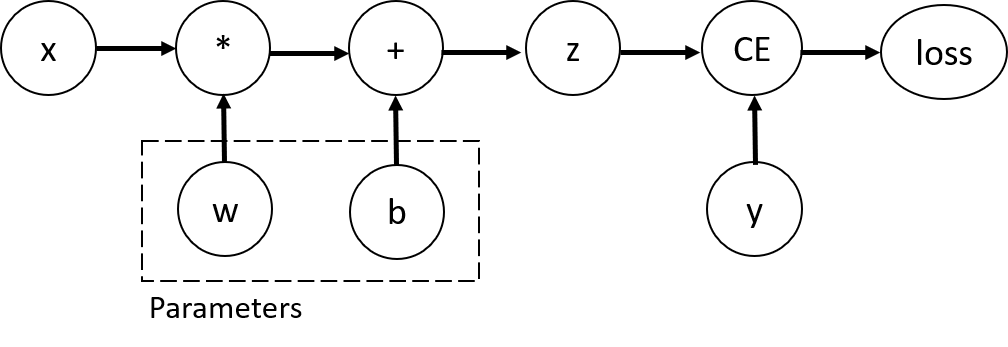

In [2]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7d42c35e8a60>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7d42c35dc730>


In [3]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.3300, 0.1365, 0.3215],
        [0.3300, 0.1365, 0.3215],
        [0.3300, 0.1365, 0.3215],
        [0.3300, 0.1365, 0.3215],
        [0.3300, 0.1365, 0.3215]])
tensor([0.3300, 0.1365, 0.3215])


Disabling Gradient tracking

In [4]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


In [5]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


# More on computational Graphs

Conceptually, autograd keeps a record of data (tensors) and all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG) consisting of Function objects. In this DAG, leaves are the input tensors, roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:

run the requested operation to compute a resulting tensor

maintain the operation’s gradient function in the DAG.

The backward pass kicks off when .backward() is called on the DAG root. autograd then:

computes the gradients from each .grad_fn,

accumulates them in the respective tensor’s .grad attribute

using the chain rule, propagates all the way to the leaf tensors.

#🧬 Real-World Analogy:
Think of it like a factory production line:

Every operation logs how it converted raw material (input tensor) to a product (output tensor).

Then when you want to know how changing raw materials affects the final product (i.e., gradient), autograd traces back the entire pipeline and calculates impact using chain rule.

🧠 Key Concepts Recap:
Concept	Meaning
DAG	Directed Acyclic Graph — maps tensor relationships
.grad_fn	Stores the function used to create a tensor
leaf tensor	Input tensors with requires_grad=True
z.backward()	Triggers gradient computation
.grad	Where gradients are stored for leaf tensors
Chain Rule	Core principle used to compute gradients

If you're ever unsure how a tensor was made, just print its .grad_fn:

python
Copy
Edit
print(z.grad_fn)
You'll see something like:

csharp
Copy
Edit
<AddBackward0 object at ...>
This tells you PyTorch knows how to compute the gradient for this operation.

Note

DAGs are dynamic in PyTorch An important thing to note is that the graph is recreated from scratch; after each .backward() call, autograd starts populating a new graph. This is exactly what allows you to use control flow statements in your model; you can change the shape, size and operations at every iteration if needed.

# Tensor gradients and Jacobian products


Usually, you have a scalar loss (like MSE or Cross Entropy), and you call:

loss.backward()
This gives you the gradient of that scalar w.r.t. each parameter — nice and easy.

But sometimes:

The output is not a scalar — it's a vector or tensor.

Then, instead of a simple gradient, you need to compute something called the Jacobian.


In short:

It shows how each output value changes with each input variable.

Why not calculate full Jacobian?
Full Jacobian matrix can be very large and memory-consuming.

PyTorch usually doesn’t need the full matrix — it just needs directional derivatives.

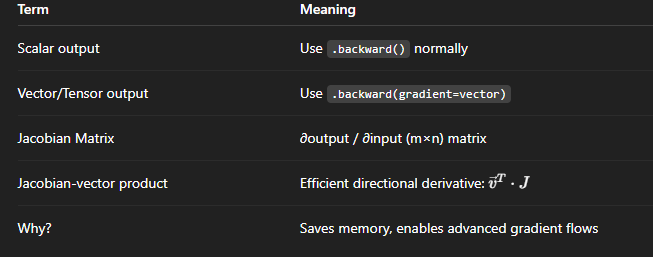

In [7]:
inp = torch.eye(4,5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"Second call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"Call after zeroing gradiends\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])
Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])
Call after zeroing gradiends
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


Notice that when we call backward for the second time with the same argument, the value of the gradient is different. This happens because when doing backward propagation, PyTorch accumulates the gradients, i.e. the value of computed gradients is added to the grad property of all leaf nodes of computational graph. If you want to compute the proper gradients, you need to zero out the grad property before. In real-life training an optimizer helps us to do this.

Note

Previously we were calling backward() function without parameters. This is essentially equivalent to calling backward(torch.tensor(1.0)), which is a useful way to compute the gradients in case of a scalar-valued function, such as loss during neural network training.